<a href="https://colab.research.google.com/github/eddiechu888/idioms/blob/main/idioms_llama3_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Enter your Hugging Face token: ··········
Using device: cuda


/usr/local/lib/python3.10/dist-packages/transformers/models/auto/tokenization_auto.py:786: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(


Pad token not found. Setting pad_token to eos_token: <|end_of_text|>


/usr/local/lib/python3.10/dist-packages/transformers/models/auto/auto_factory.py:469: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(


Hooks registered on model layers.

Processing 'idiomatic' sentence:
Sentence: She thought of good ways to break the ice at the company retreat.
Hook 'layer_0': Capturing Tensor with shape torch.Size([1, 20, 2048])
Hook 'layer_1': Capturing Tensor with shape torch.Size([1, 20, 2048])
Hook 'layer_2': Capturing Tensor with shape torch.Size([1, 20, 2048])
Hook 'layer_3': Capturing Tensor with shape torch.Size([1, 20, 2048])
Hook 'layer_4': Capturing Tensor with shape torch.Size([1, 20, 2048])
Hook 'layer_5': Capturing Tensor with shape torch.Size([1, 20, 2048])
Hook 'layer_6': Capturing Tensor with shape torch.Size([1, 20, 2048])
Hook 'layer_7': Capturing Tensor with shape torch.Size([1, 20, 2048])
Hook 'layer_8': Capturing Tensor with shape torch.Size([1, 20, 2048])
Hook 'layer_9': Capturing Tensor with shape torch.Size([1, 20, 2048])
Hook 'layer_10': Capturing Tensor with shape torch.Size([1, 20, 2048])
Hook 'layer_11': Capturing Tensor with shape torch.Size([1, 20, 2048])
Hook 'layer_12

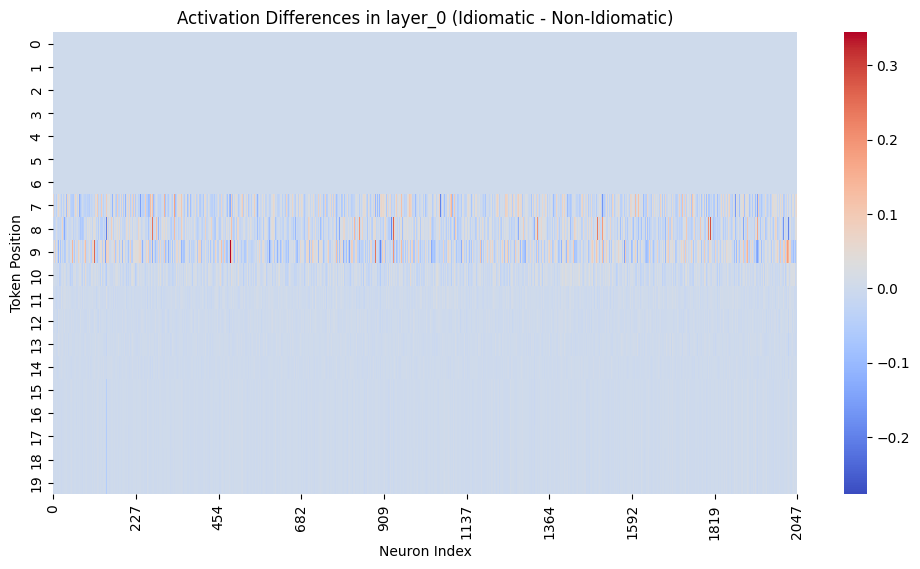

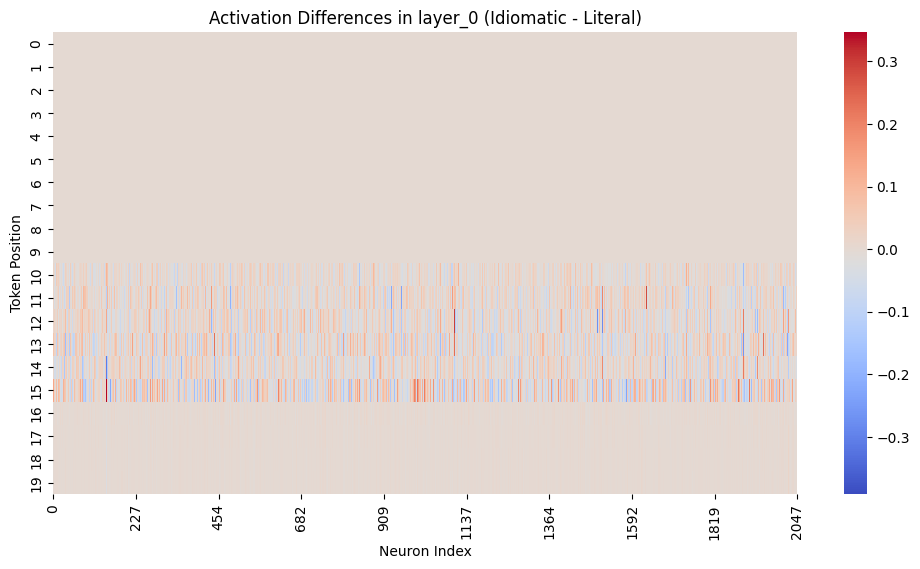

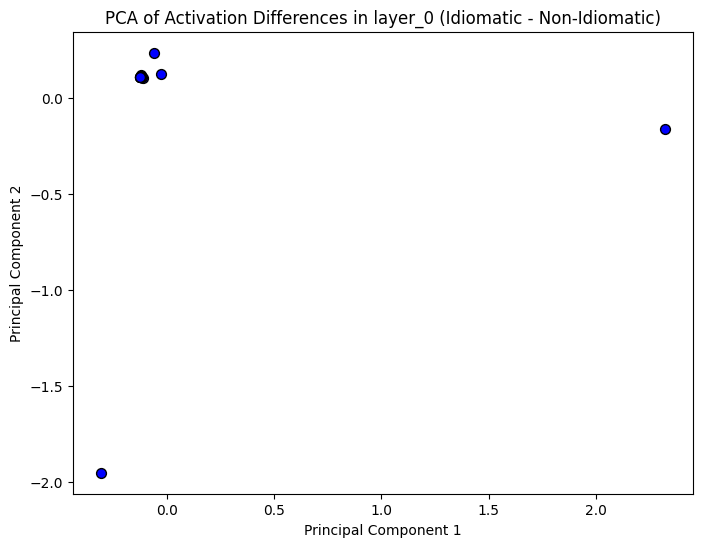

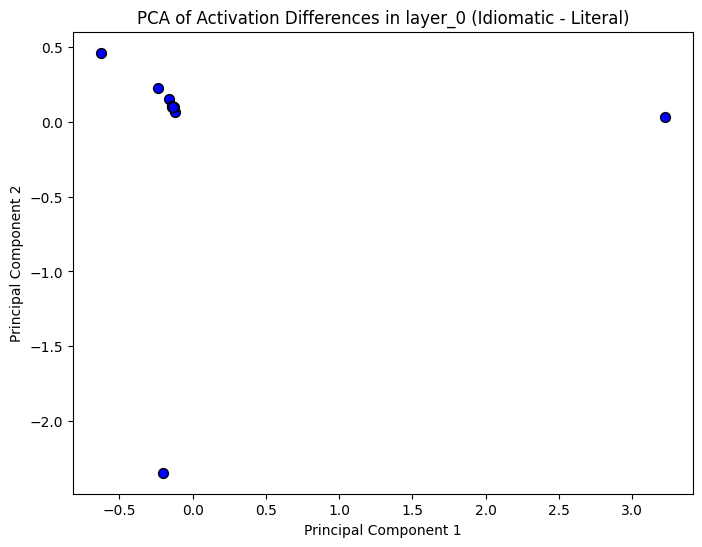

In [10]:
import torch
import numpy as np
from transformers import AutoModelForCausalLM, AutoTokenizer
from collections import defaultdict
import json
import matplotlib.pyplot as plt
import seaborn as sns
from getpass import getpass

# 1. Setup
hf_token = getpass('Enter your Hugging Face token: ')

if hf_token is None:
    raise ValueError("HUGGINGFACE_TOKEN is not set.")

model_name = 'meta-llama/Llama-3.2-1B'

# Check for CUDA and MPS availability and use the best available option
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

print(f"Using device: {device}")

# Initialize tokenizer and model with the HF token for authentication
tokenizer = AutoTokenizer.from_pretrained(model_name, use_auth_token=hf_token)

# Set pad_token to eos_token if pad_token is not already set
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token
    print(f"Pad token not found. Setting pad_token to eos_token: {tokenizer.pad_token}")
else:
    print(f"Using existing pad_token: {tokenizer.pad_token}")

model = AutoModelForCausalLM.from_pretrained(model_name, use_auth_token=hf_token).to(device)
model.eval()  # Set model to evaluation mode

# 2. Define the Single Data Example
single_example = {
    "idiomatic": "She thought of good ways to break the ice at the company retreat.",
    "non_idiomatic": "She thought of good ways to get people talking at the company retreat.",
    "literal": "She thought of good ways to break the ice to make a cold drink."
}

# 3. Define Hook for Activations
activations = defaultdict(list)

def get_activation(name):
    def hook(model, input, output):
        # If output is a tuple, extract the first element (hidden states)
        if isinstance(output, tuple):
            output = output[0]

        # If output is a list, extract the first element
        if isinstance(output, list):
            output = output[0]

        # Check if the output is a Tensor
        if isinstance(output, torch.Tensor):
            print(f"Hook '{name}': Capturing Tensor with shape {output.shape}")
            activations[name].append(output.detach().cpu())
        else:
            print(f"Hook '{name}': Output is of type {type(output)}, skipping.")
    return hook

# Register hooks on desired layers
# It's crucial to inspect the model architecture to correctly access the transformer layers.
# For LLaMA models, the transformer layers are typically under model.model.layers
# Adjust the attribute path if necessary.

for i, layer in enumerate(model.model.layers):
    layer_name = f'layer_{i}'
    layer.register_forward_hook(get_activation(layer_name))

print("Hooks registered on model layers.")

# 4. Function to Process a Sentence and Capture Activations
def process_sentence(sentence, max_length=20):
    encoded_input = tokenizer(
        sentence,
        return_tensors='pt',
        padding='max_length',
        truncation=True,
        max_length=max_length
    ).to(device)
    with torch.no_grad():
        model(**encoded_input)
    # After forward pass, activations are populated via hooks
    return

# 5. Process Each Sentence in the Triplet
conditions = ['idiomatic', 'non_idiomatic', 'literal']
condition_activations = {condition: defaultdict(list) for condition in conditions}

for condition in conditions:
    sentence = single_example[condition]
    print(f"\nProcessing '{condition}' sentence:")
    print(f"Sentence: {sentence}")

    # Clear previous activations
    activations.clear()

    # Process the sentence
    process_sentence(sentence)

    # Store activations
    for layer, act in activations.items():
        condition_activations[condition][layer].extend(act)

    print(f"Activations captured for '{condition}' condition.")

# 6. Analyze and Compare Activations
# For simplicity, we'll compute the average activation for each layer and visualize differences.

def compute_average_activation(activations_dict):
    average_activation = {}
    for layer, acts in activations_dict.items():
        # Stack all activations for the layer (should be only one in this case)
        stacked = torch.cat(acts, dim=0)  # Shape: [batch_size, ...]
        # Compute the mean across the batch dimension
        average = stacked.mean(dim=0)
        average_activation[layer] = average
    return average_activation

avg_idiomatic = compute_average_activation(condition_activations['idiomatic'])
avg_non_idiomatic = compute_average_activation(condition_activations['non_idiomatic'])
avg_literal = compute_average_activation(condition_activations['literal'])

# Example: Compare average activations of a specific layer
layer_to_compare = 'layer_0'  # Change as needed

idiom_avg = avg_idiomatic[layer_to_compare]
non_idiom_avg = avg_non_idiomatic[layer_to_compare]
literal_avg = avg_literal[layer_to_compare]

# Compute differences
difference_idiom_non_idiom = idiom_avg - non_idiom_avg
difference_idiom_literal = idiom_avg - literal_avg

print(f"\nAverage activation difference for {layer_to_compare} (Idiomatic - Non-Idiomatic): {difference_idiom_non_idiom}")
print(f"Average activation difference for {layer_to_compare} (Idiomatic - Literal): {difference_idiom_literal}")

# 7. Visualize Activation Differences
# We'll plot the activation differences as heatmaps.

num_layers = len(model.model.layers)
print(f"The model has {num_layers} layers.")

def plot_activation_difference(difference_tensor, layer_name, condition_pair):
    difference_np = difference_tensor.numpy()

    plt.figure(figsize=(12, 6))
    sns.heatmap(difference_np, cmap='coolwarm')
    plt.title(f'Activation Differences in {layer_name} ({condition_pair})')
    plt.xlabel('Neuron Index')
    plt.ylabel('Token Position')
    plt.yticks(ticks=np.arange(0.5, len(difference_np), 1), labels=np.arange(0, len(difference_np), 1))
    plt.xticks(ticks=np.linspace(0.5, difference_np.shape[1], num=10), labels=np.linspace(0, difference_np.shape[1]-1, num=10, dtype=int))
    plt.show()

# Plotting the differences
plot_activation_difference(difference_idiom_non_idiom, layer_to_compare, 'Idiomatic - Non-Idiomatic')
plot_activation_difference(difference_idiom_literal, layer_to_compare, 'Idiomatic - Literal')

# 7. Visualize Activation Differences
def plot_all_activation_differences(avg_idiomatic, avg_non_idiomatic, avg_literal, plot_type='full', neuron_start=0, neuron_end=100):
    """
    Plots activation differences for all layers in a grid of subplots.

    Parameters:
    - avg_idiomatic (dict): Average activations for 'idiomatic' condition.
    - avg_non_idiomatic (dict): Average activations for 'non_idiomatic' condition.
    - avg_literal (dict): Average activations for 'literal' condition.
    - plot_type (str): Type of plot ('full', 'average', 'subset').
    - neuron_start (int): Starting index for neuron subset (used if plot_type='subset').
    - neuron_end (int): Ending index for neuron subset (used if plot_type='subset').
    """
    layers = sorted(avg_idiomatic.keys(), key=lambda x: int(x.split('_')[1]))
    num_layers = len(layers)

    grid_cols = 4  # Adjust based on the number of layers
    grid_rows = math.ceil(num_layers / grid_cols)

    plt.figure(figsize=(grid_cols * 5, grid_rows * 4))

    for idx, layer in enumerate(layers):
        if layer in avg_idiomatic and layer in avg_non_idiomatic and layer in avg_literal:
            idiom_avg = avg_idiomatic[layer]
            non_idiom_avg = avg_non_idiomatic[layer]
            literal_avg = avg_literal[layer]

            # Compute differences
            difference_idiom_non_idiom = idiom_avg - non_idiom_avg
            difference_idiom_literal = idiom_avg - literal_avg

            # Select which difference to plot
            # For demonstration, we'll plot 'Idiomatic - Non-Idiomatic'
            difference = difference_idiom_non_idiom  # Change as needed

            difference_np = difference.numpy()

            ax = plt.subplot(grid_rows, grid_cols, idx + 1)
            sns.heatmap(difference_np, cmap='coolwarm', ax=ax)
            ax.set_title(f'{layer}\nIdiomatic - Non-Idiomatic')
            ax.set_xlabel('Neuron Index')
            ax.set_ylabel('Token Position')

            # Adjust tick labels for clarity
            ax.set_yticks(np.arange(0.5, difference_np.shape[0], 1))
            ax.set_yticklabels(np.arange(0, difference_np.shape[0], 1))
            ax.set_xticks(np.linspace(0.5, difference_np.shape[1], num=10))
            ax.set_xticklabels(np.linspace(0, difference_np.shape[1]-1, num=10, dtype=int))

        else:
            # If layer data is missing, leave the subplot empty
            ax = plt.subplot(grid_rows, grid_cols, idx + 1)
            ax.axis('off')

    plt.tight_layout()
    plt.show()

# Call the plotting function
plot_all_activation_differences(avg_idiomatic, avg_non_idiomatic, avg_literal, plot_type='full')


from sklearn.decomposition import PCA

def plot_pca(difference_tensor, layer_name, condition_pair):
    difference_np = difference_tensor.numpy()

    pca = PCA(n_components=2)
    principal_components = pca.fit_transform(difference_np)

    plt.figure(figsize=(8, 6))
    plt.scatter(principal_components[:, 0], principal_components[:, 1], c='blue', edgecolor='k', s=50)
    plt.title(f'PCA of Activation Differences in {layer_name} ({condition_pair})')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.show()

# Example usage:
plot_pca(difference_idiom_non_idiom, layer_to_compare, 'Idiomatic - Non-Idiomatic')
plot_pca(difference_idiom_literal, layer_to_compare, 'Idiomatic - Literal')